# Depth Estimation with MiDaS

This notebook demonstrates how to use the depth estimation module to generate depth maps from RGB images using the MiDaS model.

In [1]:
import os
import sys
from pathlib import Path

# Add the project root to the Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from src.depth_estimation.midas import DepthEstimator
from src.depth_estimation.utils import normalize_depth_map, save_depth_visualization

## Initialize the Depth Estimator

First, we need to initialize the depth estimator with the desired MiDaS model variant. There are three options:

- `MiDaS_small`: Faster but less accurate
- `DPT_Large`: Highest accuracy but slower
- `DPT_Hybrid`: Balance between speed and accuracy

For this demonstration, we'll use the small model for faster inference.

In [3]:
# Create the depth estimator
estimator = DepthEstimator(model_type="MiDaS_small")
print(f"Using device: {estimator.device}")

2025-05-08 16:29:06,376 - src.depth_estimation.midas - INFO - Using device: cuda
2025-05-08 16:29:06,376 - src.depth_estimation.midas - INFO - Loading MiDaS model: MiDaS_small
c:\Users\zhiwe\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to C:\Users\zhiwe/.cache\torch\hub\master.zip
c:\Users\zhiwe\Lib\site-packages\timm\models\layers\__init__.py:48: Future

Loading weights:  None


c:\Users\zhiwe\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to C:\Users\zhiwe/.cache\torch\hub\master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to C:\Users\zhiwe/.cache\torch\hub\checkpoints\tf_efficientnet_lite3-b733e338.pth
Downloading: "http

Using device: cuda


## Process a Sample Image

Now, let's process a sample image to generate a depth map. First, you need to download or copy an image to the `data/images` directory.

In [5]:
# Check if there are any images in the data/images directory
image_dir = project_root / "data" / "images"
image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

if not image_files:
    print("No images found in data/images directory.")
    print("Please download or copy some images to the data/images directory.")
else:
    print(f"Found {len(image_files)} images in data/images directory:")
    for img_file in image_files:
        print(f"  - {img_file.name}")

Found 1 images in data/images directory:
  - Screenshot 2025-05-08 at 16-30-36 midas model pytorch test images - Google Search.png


If no images are found, you can use the following cell to download a sample image:

In [6]:
# Download a sample image if none exist
if not image_files:
    import requests
    from PIL import Image
    from io import BytesIO
    
    # URL of a sample image
    sample_img_url = "https://github.com/intel-isl/MiDaS/raw/master/utils/img/pexels-photo-4200563.jpeg"
    
    # Download the image
    response = requests.get(sample_img_url)
    img = Image.open(BytesIO(response.content))
    
    # Save the image
    os.makedirs(image_dir, exist_ok=True)
    sample_img_path = image_dir / "sample.jpg"
    img.save(sample_img_path)
    
    print(f"Downloaded sample image to {sample_img_path}")
    image_files = [sample_img_path]

Now, let's process the first image in the list:

In [7]:
# Process the first image
img_path = image_files[0]
print(f"Processing image: {img_path}")

# Estimate depth
rgb_image, depth_map = estimator.estimate_depth(img_path)

print(f"RGB image shape: {rgb_image.shape}")
print(f"Depth map shape: {depth_map.shape}")
print(f"Depth map min: {depth_map.min():.2f}, max: {depth_map.max():.2f}")

2025-05-08 16:31:25,005 - src.depth_estimation.midas - INFO - Processing image: c:\Users\zhiwe\OneDrive\Documents\ML@B\FinalP\data\images\Screenshot 2025-05-08 at 16-30-36 midas model pytorch test images - Google Search.png


Processing image: c:\Users\zhiwe\OneDrive\Documents\ML@B\FinalP\data\images\Screenshot 2025-05-08 at 16-30-36 midas model pytorch test images - Google Search.png


2025-05-08 16:31:26,388 - src.depth_estimation.midas - INFO - Depth estimation completed successfully


RGB image shape: (300, 532, 3)
Depth map shape: (300, 532)
Depth map min: -10.70, max: 671.81


## Visualize the Results

Let's visualize the RGB image and its corresponding depth map side by side:

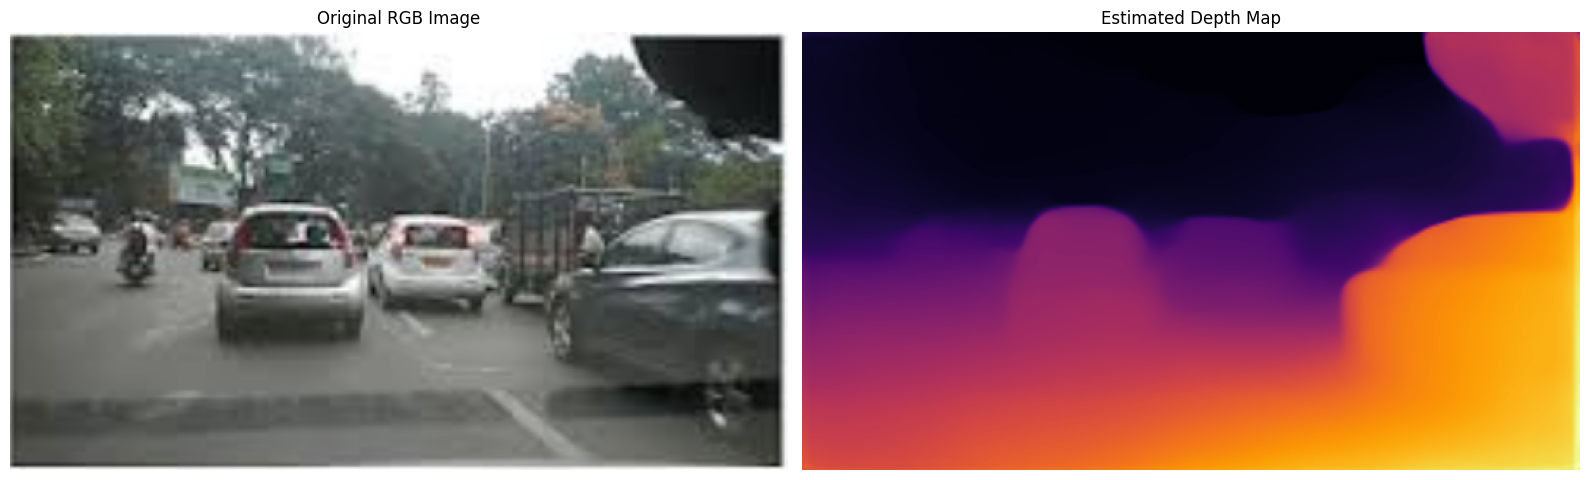

In [8]:
# Visualize the results
plt.figure(figsize=(16, 8))

# Original RGB image
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title("Original RGB Image")
plt.axis("off")

# Depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap="inferno")
plt.title("Estimated Depth Map")
plt.axis("off")

plt.tight_layout()
plt.show()

Let's explore different color maps for the depth map visualization:

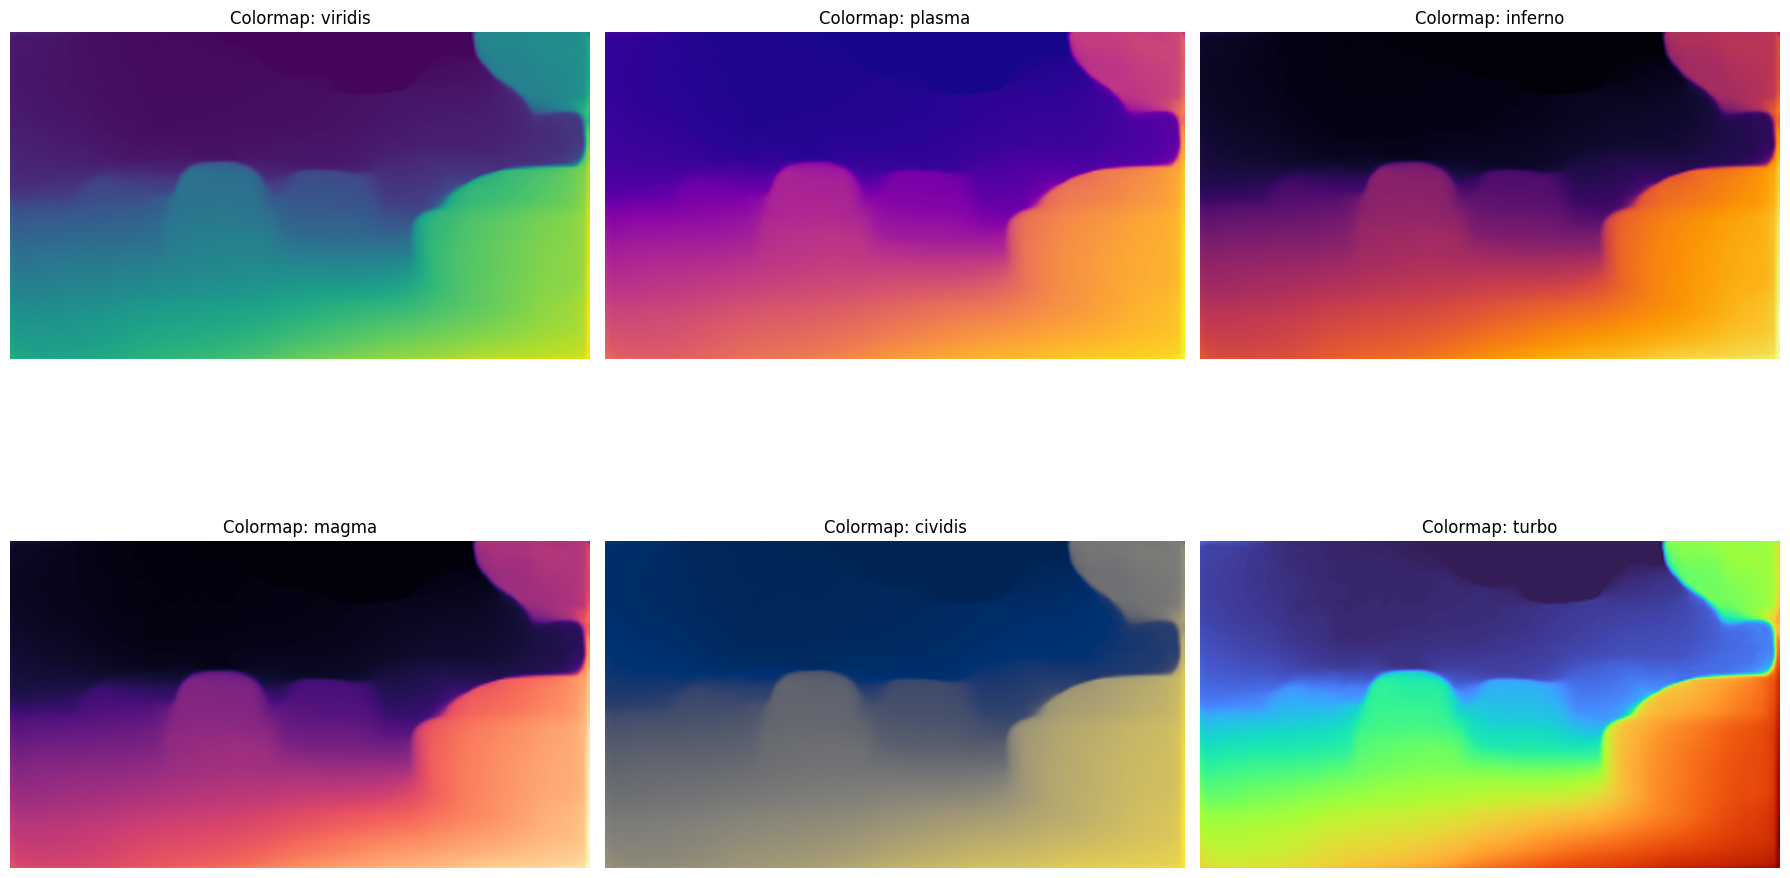

In [9]:
# Visualize with different colormaps
colormaps = ["viridis", "plasma", "inferno", "magma", "cividis", "turbo"]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, cmap in enumerate(colormaps):
    axes[i].imshow(depth_map, cmap=cmap)
    axes[i].set_title(f"Colormap: {cmap}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## Save the Results

Now, let's save the depth map and visualization to the results directory:

In [10]:
from src.depth_estimation.utils import save_depth_map, export_depth_data, save_depth_visualization

# Create results directory
results_dir = project_root / "results"
os.makedirs(results_dir, exist_ok=True)

# Save visualization
vis_path = results_dir / f"{img_path.stem}_depth_vis.png"
save_depth_visualization(rgb_image, depth_map, vis_path)
print(f"Saved visualization to {vis_path}")

# Save colored depth map
depth_path = results_dir / f"{img_path.stem}_depth.png"
save_depth_map(depth_map, depth_path)
print(f"Saved depth map to {depth_path}")

# Save raw depth data
raw_path = results_dir / f"{img_path.stem}_depth.npy"
export_depth_data(depth_map, raw_path)
print(f"Saved raw depth data to {raw_path}")

Saved visualization to c:\Users\zhiwe\OneDrive\Documents\ML@B\FinalP\results\Screenshot 2025-05-08 at 16-30-36 midas model pytorch test images - Google Search_depth_vis.png
Saved depth map to c:\Users\zhiwe\OneDrive\Documents\ML@B\FinalP\results\Screenshot 2025-05-08 at 16-30-36 midas model pytorch test images - Google Search_depth.png
Saved raw depth data to c:\Users\zhiwe\OneDrive\Documents\ML@B\FinalP\results\Screenshot 2025-05-08 at 16-30-36 midas model pytorch test images - Google Search_depth.npy


## Process All Images

Finally, let's process all images in the data/images directory and save the results:

In [ ]:
# Process all images
for img_path in image_files:
    print(f"Processing image: {img_path.name}")
    
    try:
        # Estimate depth
        rgb_image, depth_map = estimator.estimate_depth(img_path)
        
        # Save results
        vis_path = results_dir / f"{img_path.stem}_depth_vis.png"
        depth_path = results_dir / f"{img_path.stem}_depth.png"
        raw_path = results_dir / f"{img_path.stem}_depth.npy"
        
        save_depth_visualization(rgb_image, depth_map, vis_path)
        save_depth_map(depth_map, depth_path)
        export_depth_data(depth_map, raw_path)
        
        print(f"  - Processed successfully")
    except Exception as e:
        print(f"  - Error processing {img_path.name}: {e}")

print("Processing complete!")

## Conclusion

In this notebook, we've demonstrated how to use the MiDaS model for monocular depth estimation. The generated depth maps can be used in the next phase of the project for creating navigable grid environments for reinforcement learning agents.